Author: Angelina Espinoza-Limon

Project 1.

This project presents the CRISP-DM process for the financial data analysis in order to identifying what is the behaviour of the variables, which affect the identification of suspicious transactions from raw data. Several business questions are defined to guide the analysis that will be answered through this analysis. Thereafter, it is firstly analysed the data to find out which variables are mostly affecting the fraud detection, and then to model a suitable machine learning algorithm. This analysis include to perform a bias-variance trade-off to evaluate the model precision, through the AUPRC error score curve. 

The dataset to be used in this analysis is a synthetic dataset <a href='https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION'>[1]</a> which has been created with an agent-based simulator based on "a sample of real transactions extracted from the logs of a mobile money service implemented in an African country" <a href='https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION'>[1]</a>.

<a id='top'></a>

#### Project 1: CRISP-DM for Identifying Fraudulent Transactions 
#### 1. <a href='#BusinessUnders'>Business Understanding</a>


#### 2. <a href='#dataunders'>Data Understanding</a>
21. <a href='#datagathering'>Data Gathering</a>
22. <a href='#datacleaning'>Data Cleaning</a>
23. <a href='#missingvalues'>Managing Missing Values</a>
24. <a href='#analysingdata'>Analysing the Data</a>

#### 3. <a href='#datapreparation'>Data Preparation</a>
31. <a href='#dataremoval'>Data Removal</a>
32. <a href='#dataimputation'>Data Imputation</a>
32. <a href='#featureEng'>Feature Engineering</a>

#### 4. <a href='#modeling'>Modeling</a>
41. <a href='#ModelSelection'>Model Selection</a>
41. <a href='#ModelTraining'>Model Training and Testing</a>
42. <a href='#ModelVisualization'>Model Visualization</a>

#### 5. <a href='#evaluation'>Evaluation</a>
51. <a href='#biasvariance'>Bias-variance tradeoff</a>

#### 6. <a href='#deployment'>Deployment</a>

#### 7. <a href='#conclusion'>Conclusion</a>

<a id='BusinessUnders'></a>
#### 1. Business Understanding
<p> In this section, it is defined the Business Questions to guide the analysis for fraud detection on financial data, as follows: </p> 
<a href='#MainChallenge'>1.1 What is the main challenge in monitoring suspicious transactions as fraud in financial institutions?</a>
<p> <a href='#fraud-bigAmount'>1.2 Do mostly fraudulent transactions occur with big amounts of money?</a>
<p> <a href='#fraud-CashOut'>1.3 Do mostly common fraudulent transactions occur in cash out?</a>
<p> <a href='#fraud-indicator'>1.4 What could be a fraud indicator?</a>
<p> <a href='#fraud-preds'>1.5 Is it possible to predict that a specific transaction is suspicious of fraud?</a>

<a id='dataunders'></a>
#### 2. Data Understanding
In this section, it will be explored different perspectives to analyse the dataset, in order to discover the features that mostly influence a fraudulent transaction. Also this analysis will provide some insights to answer the business questions. For this analysis, it will be used the Dataframe functions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

import os

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

<a id='datagathering'></a>
#### 2.1 Data Gathering


The dataset to be used is synthetic data produced with an agent-based simulation software, which uses an orignial and real dataset as baseline to generate more than 6 million of financial transactions. This dataset is introduced and documented by its authors in: E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection", in the 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016. 
The dataset is available in Kaggle: https://www.kaggle.com/ntnu-testimon/paysim1

Therefore, the data gathering is already done by the authors of this dataset. 

In the following there are the columns renaming, in order to use a more meaningful column name, according to the financial transaction domain.

In [3]:
#arc_datos= open(os.getcwd()+'\\iris.data','r')
df = pd.read_csv("D:\\Angie\Trainings\\Cursados\\UCSC-Udacity\\Project1\\Data\\PS_20174392719_1491204439457_log-full.csv", low_memory=False, dtype={"oldBalanceDest": np.float64, "newBalanceDest": np.float64})
df = df.rename(columns={'step':'Step', 'type':'TransactionType', 'amount':'Amount',  'nameOrig':'OriginAccount', \
                        'oldbalanceOrg':'OldBalanceOrigin', 'newbalanceOrig':'NewBalanceOrigin', 'nameDest':'DestinationAccount',\
                        'oldbalanceDest':'OldBalanceDestination', 'newbalanceDest':'NewBalanceDestination'})


In [4]:
# Printing out the records number in the dataset and the head
print(df.shape[0])
df.head()

6362620


,Step,TransactionType,Amount,OriginAccount,OldBalanceOrigin,NewBalanceOrigin,DestinationAccount,OldBalanceDestination,NewBalanceDestination,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<a id='datacleaning'></a>
#### 2.2 Data Cleaning


In [5]:
# To obtain the columns datatypes
df.dtypes

Step                       int64
TransactionType           object
Amount                   float64
OriginAccount             object
OldBalanceOrigin         float64
NewBalanceOrigin         float64
DestinationAccount        object
OldBalanceDestination    float64
NewBalanceDestination    float64
isFraud                    int64
isFlaggedFraud             int64
dtype: object

In [6]:
# To change the columns types from object to string and bool, according to the columns meaning

# This column indicates the transaction type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
df['TransactionType'] = df['TransactionType'].astype(dtype='string')

# This column indicates the account number in the origin institution
df['OriginAccount'] = df['OriginAccount'].astype(dtype='string')

# This column indicates the account number in the destination institution
df['DestinationAccount'] = df['DestinationAccount'].astype(dtype='string')

# This column indicates if the transaction is fraud, so it is a boolean
df['isFraud'] = df['isFraud'].astype(dtype='bool') 

# This column indicates if the transaction was set as fraud during the transaction occurrence, so it is a boolean
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype(dtype='bool') 

df.dtypes

Step                       int64
TransactionType           string
Amount                   float64
OriginAccount             string
OldBalanceOrigin         float64
NewBalanceOrigin         float64
DestinationAccount        string
OldBalanceDestination    float64
NewBalanceDestination    float64
isFraud                     bool
isFlaggedFraud              bool
dtype: object

<a id='missingvalues'></a>
#### 2.3 Managing Missing values
The following code tests if there are missing values in the dataset. The results indicate that there are no
missing values (e.g. nan's); however, it is still possible that some transactions have the number zero in the account balances, but I will keep these ones to avoid hidding financial reasons in this situations. This will be analysed later on in this notebook.

In [7]:
# To find out how many null values the dataframe has.
df.isnull().values.any()

False

<a href='#top'>back to top</a>

<a id='analysingdata'></a>
#### 2.4 Analysing the Data

For responding the question: 
<a id='MainChallenge'>1.1 What is the main challenge in monitoring suspicious transactions as fraud in financial institutions?</a>

We will see through the next code, that one of the main challenges that poses the fruad identification is the imbalance of the data. Basically, more than 99% of the data correspond to valid transactions (no fraud), and just the remaining is corresponding to fraud ones. In this scenario and for modeling a ML algorithm, this data need to be prepared with suitable strategies for this kind of skewed data.

In [8]:
# Get the mean of the fraud transactions
print('\n The average of fraudulent transactions is {}%'.format( round( ((df['isFraud'].mean())*100), 2)))

# Get the mean of the no-fraud transactions
print('\n The average of non-fraudulent transactions is {}%'.format(\
    round((df[(df.isFraud == 0)]['isFraud'].count()/df.shape[0]) * 100,2) ))


 The average of fraudulent transactions is 0.13%

 The average of non-fraudulent transactions is 99.87%


In [9]:
print('\n The fraudulent transactions is {}'.format(df[(df.isFraud == 1)]['isFraud'].count() ) )
print('\n The non-fraudulent transactions is {}'.format(df[(df.isFraud == 0)]['isFraud'].count() ) )


 The fraudulent transactions is 8213

 The non-fraudulent transactions is 6354407


<AxesSubplot:xlabel='isFraud'>

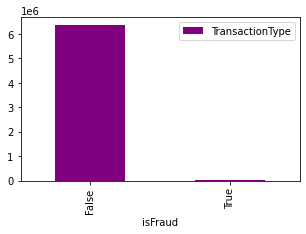

In [10]:
plotdata = df[['TransactionType','isFraud']]

#plotdata.count().plot(kind='bar', stacked=True)
plotdata.groupby(['isFraud']).count().plot(kind='bar', color=['purple'], figsize=(5,3))

<AxesSubplot:xlabel='isFraud', ylabel='Amount'>

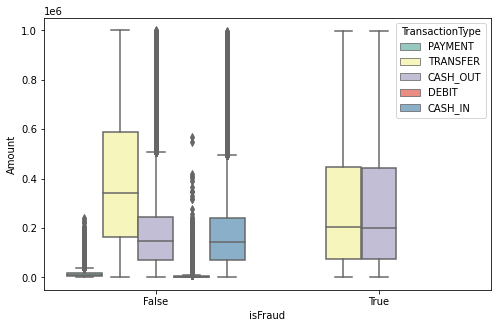

In [11]:
# To plot the transactions against the transacted amount, indicating the fraudulent ones.
plt.figure(figsize=(8,5))
sns.boxplot(x = 'isFraud', y = 'Amount', hue= "TransactionType", data = df[df.Amount < 1e6], palette="Set3")

The following code analyses how many transactions were originally set as fraud in the dataset. For this, the isFlaggedFraud column is used.

It can be observed that from the entire dataset with more than 6 million of transactions, only 16 of them were set as fraudelent during the transaction occurence.

In [12]:
print('\n The number of transactions that have been set while occurring is {} which are printed out as follows:'.\
      format(df['isFlaggedFraud'].sum()) )

df.loc[df['isFlaggedFraud'] == 1]


 The number of transactions that have been set while occurring is 16 which are printed out as follows:


,Step,TransactionType,Amount,OriginAccount,OldBalanceOrigin,NewBalanceOrigin,DestinationAccount,OldBalanceDestination,NewBalanceDestination,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,True,True
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,True,True
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,True,True
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,True,True
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,True,True
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,True,True
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,True,True
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,True,True
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,True,True
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,True,True


<AxesSubplot:xlabel='isFlaggedFraud', ylabel='Amount'>

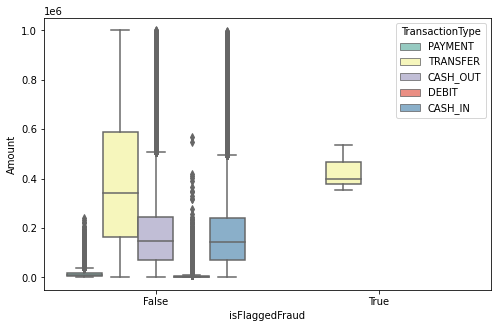

In [13]:
# To plot the transactions against the transacted amount, indicating the fraudulent ones.
plt.figure(figsize=(8,5))
sns.boxplot(x = 'isFlaggedFraud', y = 'Amount', hue= "TransactionType", data = df[df.Amount < 1e6], palette="Set3")

<a href='#top'>back to top</a>

For answering the question: 
<a id='fraud-bigAmount'>1.2 Do mostly fraudulent transactions occur with big amounts of money?</a>

From the next code, it can be observed that the fraudulent transactions mostly occurred as CASH_OUT or TRANSFER types, in asimilar number: 4097 for TRANSFERs and 4116 for CASH_OUTs.

In [14]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].TransactionType.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFrauTransfers = df.loc[(df.isFraud == 1) & (df.TransactionType == 'TRANSFER')]
dfFrauCashOuts = df.loc[(df.isFraud == 1) & (df.TransactionType == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFrauTransfers))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFrauCashOuts))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116



From the cell below, the averange transacted amount in TRANSFERs is 1480891.67, and the averange transacted amount in CASH_OUTs is 1455102.59.

If we count the transfers less than the average, we got 3043 transactions and only 1054 greater than the everage. This means that mostly the fraud occurred in small transacted amounts; however if the number of transfers that are less than 400,000 we got 1954, which means that from the fraud transactions under the average transacted amount, the most of them occurred in very small amounts. Thus, it can be concluded that mostly the fraud transfers occurred in the extremes, either in big amounts or in small amounts.

This similar reasoning can be figured it out for the transactions of the CASH_OUT type; the cashouts less than the average is 3058, and 1058 are greater than the average. The cashouts occurred in very small amounts are 1986.

Thus, we can infered that either fraudulent transfers or cashouts, both present the same pattern; mostly occurred in very small amounts of money. This makes sense since fraudters will try to hide the money in short amount transactions, instead of operating with big amounts of money, which immediately will be detected by the financial institutions' systems.

In [15]:
print('\nThe average transacted amount of fraudulent TRANSFERs is {}, being the minimum as {} and the maximum {}.'.format(\
round(dfFrauTransfers['Amount'].mean(),2), round(dfFrauTransfers['Amount'].min(), 2), round(dfFrauTransfers['Amount'].max(),2)))

less_avrg = dfFrauTransfers[dfFrauTransfers['Amount']<dfFrauTransfers['Amount'].mean()].Amount.count()
greater_avrg = dfFrauTransfers[dfFrauTransfers['Amount']>=dfFrauTransfers['Amount'].mean()].Amount.count()


print(dfFrauTransfers['Amount'].count())

print('\nThe number of fraudulent TRANSFERs that are less than the average is {}.'.format(less_avrg) )

print('\nThe number of fraudulent TRANSFERs that are greater than the average is {}.'.format(greater_avrg) )


print('\nThe number fraudulent TRANSFERs that are less than 400,000 is {}, which is the {}% of the total fraudulent ones.'.format(\
    dfFrauTransfers[dfFrauTransfers['Amount']<400000].Amount.count(), \
    round((dfFrauTransfers[dfFrauTransfers['Amount']<400000].Amount.count()/dfFrauTransfers['Amount'].count())*100, 2) ))


The average transacted amount of fraudulent TRANSFERs is 1480891.67, being the minimum as 63.8 and the maximum 10000000.0.
4097

The number of fraudulent TRANSFERs that are less than the average is 3043.

The number of fraudulent TRANSFERs that are greater than the average is 1054.

The number fraudulent TRANSFERs that are less than 400,000 is 1954, which is the 47.69% of the total fraudulent ones.


In [16]:
print('\nThe average transacted amount of fraudulent CASH_OUTs is {}, being the minimun as {} and the maximum {}.'.format(\
round(dfFrauCashOuts['Amount'].mean(),2), round(dfFrauCashOuts['Amount'].min(), 2), round(dfFrauCashOuts['Amount'].max(),2)))

print('\nThe number fraudulent CASH_OUTs that are less than the average is {}.'.format(\
    dfFrauCashOuts[dfFrauCashOuts['Amount']<dfFrauCashOuts['Amount'].mean()].Amount.count()) )

print('\nThe number fraudulent CASH_OUTs that are greater than the average is {}.'.format(\
    dfFrauCashOuts[dfFrauCashOuts['Amount']>=dfFrauCashOuts['Amount'].mean()].Amount.count()) )

print('\nThe number fraudulent CASH_OUTs that are less than 400,000 is {}.'.format(\
    dfFrauCashOuts[dfFrauCashOuts['Amount']<400000].Amount.count()) )


The average transacted amount of fraudulent CASH_OUTs is 1455102.59, being the minimun as 0.0 and the maximum 10000000.0.

The number fraudulent CASH_OUTs that are less than the average is 3058.

The number fraudulent CASH_OUTs that are greater than the average is 1058.

The number fraudulent CASH_OUTs that are less than 400,000 is 1986.


For answering the question: <a id='fraud-CashOut'>1.3 Do mostly common fraudulent transactions occur in cash out?</a>

The next code analyzes the transactions that are set as fraud, by using the column isFraud, even the column isFlaggedFraud has been set to false (which might be happening becaused the transactions was not set as fraud during the occurrence, but later on). 

It can be observed that only the transactions: CASH_OUT and TRANSFER have frudulent transactions, and both in almost equal number: 4116 and 4097 respectively. 

Thus, it can be concluded that fraudulent transactions can occurred in either types, cash out or transfer, which means that fruadters are using not only payment methods, but also transactions through financial institutions (and from the previous business question: <a id='fraud-bigAmount'>1.2</a>, in small amounts of money).

In [17]:
# Get the records with isFraud set as 1, group by the transaction type

df.groupby(['TransactionType', 'isFraud']).count()

Step   Amount  OriginAccount  OldBalanceOrigin  \
TransactionType isFraud                                                      
CASH_IN         False    1399284  1399284        1399284           1399284   
CASH_OUT        False    2233384  2233384        2233384           2233384   
                True        4116     4116           4116              4116   
DEBIT           False      41432    41432          41432             41432   
PAYMENT         False    2151495  2151495        2151495           2151495   
TRANSFER        False     528812   528812         528812            528812   
                True        4097     4097           4097              4097   

                         NewBalanceOrigin  DestinationAccount  \
TransactionType isFraud                                         
CASH_IN         False             1399284             1399284   
CASH_OUT        False             2233384             2233384   
                True                 4116                4116   
DEBIT           False               41432               41432   
PAYMENT         False             2151495             2151495   
TRANSFER        False              528812              528812   
                True                 4097                4097   

                         OldBalanceDestination  NewBalanceDestination  \
TransactionType isFraud                                                 
CASH_IN         False                  1399284                1399284   
CASH_OUT        False                  2233384                2233384   
                True                      4116                   4116   
DEBIT           False                    41432                  41432   
PAYMENT         False                  2151495                2151495   
TRANSFER        False                   528812                 528812   
                True                      4097                   4097   

                         isFlaggedFraud  
TransactionType isFraud                  
CASH_IN         False           1399284  
CASH_OUT        False           2233384  
                True               4116  
DEBIT           False             41432  
PAYMENT         False           2151495  
TRANSFER        False            528812  
                True               4097

<a href='#top'>back to top</a>

<a id='datapreparation'></a>
#### 3. Data Preparation
In this section, it will be wrangled the data to prepare it for analysing whether more suitable inferences can be made for answering the business questions: 1.4 and 1.5, and for modelling an ML algorithm for predicting if a transaction is fraudulent. 

<a id='dataremoval'></a>
#### 3. 1 Data Removal
As it was observed from the <a id='analysingdata'>2.4 Analysing the Data</a> section, the data register fraud transactions only in the TRANSFERs and CASH_OUTs types ones, according to the previous anaylisis for the isFraud column. So, we can freely discard the other transactions types since they are not contribuiting to figure out a fraud pattern, and avoiding carrying a bias due to the no-fraudulent transactions would be more than 99% of the records (see <a id='analysingdata'>2.4</a>). The drop of these features will also contribute to reduce variance, by avoiding the ML algorithm (e.g. a classifier) to memorize the data and prevent overfitting. 

Thus, the X dataframe is created containing only these transactions types, in order to prepare the data for a suitable prediction algorithm. 

In [18]:

# Create a dataframe with only the TRANSFER and CASH_OUT transaction types
X = df.loc[(df.TransactionType == 'TRANSFER') | (df.TransactionType == 'CASH_OUT')]

# To create and index for the dataframe
#randomState = 5
#np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']  # Create the labels for the dataframe, by assigning the isFraud column to the Y
del X['isFraud']  # Delete the isFraud column from X

# It will be eliminated the OriginAccount and DestinationAccount since they are the account numbers
X = X.drop(['OriginAccount', 'DestinationAccount'], axis = 1)

# The isFlaggedFraud is also dropped since only 16 transactions were set as fraudulent while occurring, 
# so it is a very small sample to get information from it

X = X.drop(['isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.TransactionType == 'TRANSFER', 'TransactionType'] = str(0)
X.loc[X.TransactionType == 'CASH_OUT', 'TransactionType'] = str(1)
X.TransactionType = X.TransactionType.astype(int) # convert dtype(string) to to dtype(int)



<a href='#top'>back to top</a>

<a id='dataimputation'></a>
##### 3.2 Data Imputation

There is an interesting observation in the data, it turns out that there are several transactions with zero in the destination account balance, both before and after the intended transacted amount, which is non-zero. The percentage of these transactions in fraudulent ones is 49.56%, while in the valid transactions is 0.06% (see the code below). 

The no-changed balance and non-zero transacted amount can be a strong indicator of fraud, since the financial institutions systems stop the transactions that are suspicious of fraud, and then they are not completed, leading to keep the destination account balances with no change.

In [19]:

XFrauds = X.loc[Y == 1]             # Get the fraud transactions
XNoFrauds = X.loc[Y == 0]           # Get the no-fraud transactions

print('\nThe fraudulent transactions percentage with Old Balance and New Balance in the Destination Account equals to Zero \
even the transacted amount is non-zero is: {}%'.\
format(round((len(XFrauds.loc[(XFrauds.OldBalanceDestination == 0) & \
(XFrauds.NewBalanceDestination == 0) & (XFrauds.Amount)]) / (1.0 * len(XFrauds)))*100,2)))

print('\nThe non-fraudulent transactions percentage with Old Balance and New Balance in the Destination Account equals to Zero \
even the transacted amount is non-zero is: {}%'.\
format(round((len(XNoFrauds.loc[(XNoFrauds.OldBalanceDestination == 0) & \
(XNoFrauds.NewBalanceDestination == 0) & (XNoFrauds.Amount)]) / (1.0 * len(XNoFrauds)))*100,2)))


The fraudulent transactions percentage with Old Balance and New Balance in the Destination Account equals to Zero even the transacted amount is non-zero is: 49.56%

The non-fraudulent transactions percentage with Old Balance and New Balance in the Destination Account equals to Zero even the transacted amount is non-zero is: 0.06%


In [20]:
XFrauds.head()

,Step,TransactionType,Amount,OldBalanceOrigin,NewBalanceOrigin,OldBalanceDestination,NewBalanceDestination
2,1,0,181.0,181.0,0.0,0.0,0.0
3,1,1,181.0,181.0,0.0,21182.0,0.0
251,1,0,2806.0,2806.0,0.0,0.0,0.0
252,1,1,2806.0,2806.0,0.0,26202.0,0.0
680,1,0,20128.0,20128.0,0.0,0.0,0.0


In [21]:
# This code block is for identifying the behaviour in the transactions, to show that the old and new balances in the 
# destination (and origin) accounts, even the transacted amount is non-zero

# Get the fraudulent transactions that have zero balance in the destination accounts

x1 = round(len(XFrauds.loc[(XFrauds.OldBalanceDestination == 0) & 
(XFrauds.NewBalanceDestination == 0) & (XFrauds.Amount)]) / (1.0 * len(XFrauds))*100,2)

# Get the fraudulent transactions that have zero balance in the destination accounts

x2 = round(len(XNoFrauds.loc[(XNoFrauds.OldBalanceDestination == 0) & \
(XNoFrauds.NewBalanceDestination == 0) & (XNoFrauds.Amount)]) / (1.0 * len(XNoFrauds))*100, 2)

index=['UnchangedBalance', 'ChangedBalance']
data = {'Frauds': [x1, 100-x1],
        'NonFrauds': [x2, 100-x2]
        }

dfZero = pd.DataFrame(data, index=index)
print(dfZero.head())

# Get the fraudulent transactions that have zero balance in the origin accounts

x3 = round(len(XFrauds.loc[(XFrauds.OldBalanceOrigin == 0) & 
(XFrauds.NewBalanceOrigin == 0) & (XFrauds.Amount)]) / (1.0 * len(XFrauds))*100,2)

# Get the fraudulent transactions that have zero balance in the origin accounts

x4 = round(len(XNoFrauds.loc[(XNoFrauds.OldBalanceOrigin == 0) & \
(XNoFrauds.NewBalanceOrigin == 0) & (XNoFrauds.Amount)]) / (1.0 * len(XNoFrauds))*100, 2)

index=['UnchangedDestination', 'ChangedDestination']
data2 = {'Frauds': [x3, 100-x3],
        'NonFrauds': [x4, 100-x4]
        }

dfUnchanged = pd.DataFrame(data2, index=index)
print(dfUnchanged.head())


                  Frauds  NonFrauds
UnchangedBalance   49.56       0.06
ChangedBalance     50.44      99.94
                      Frauds  NonFrauds
UnchangedDestination     0.3      47.37
ChangedDestination      99.7      52.63


Text(0, 0.5, 'Percentages')

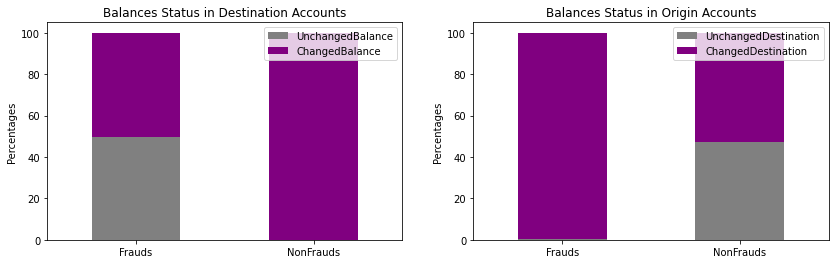

In [22]:
# To plot the unchanged balances for origin and destination accounts

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1 = dfZero.T.plot.bar(ax=ax1, rot=0, stacked=True, figsize=(14,4), color=['grey', 'purple'])
ax1.set_title('Balances Status in Destination Accounts')
ax1.set_ylabel('Percentages')

ax2 = dfUnchanged.T.plot.bar(ax=ax2, rot=0, stacked=True, figsize=(14,4), color=['grey', 'purple'])
ax2.set_title('Balances Status in Origin Accounts')
ax2.set_ylabel('Percentages')


Thereafter, it will not imputed the destination account with the mean or median, since the zero balance is a strong indicator of fraud, when the transacted amount is non-zero. Otherwise, it would mask this fraud indicator behaviour and to make the fraudulent transactions to appear no-fraudulent. Thus, another value is used to impute this columns, which is to mark these transactions by replacing the 0 with the -1, in order to indicate a particular behavior for a ML algorithm.

In [23]:
# Replace the zero balance with -1
X.head()
X.loc[(X.OldBalanceDestination == 0) & (X.NewBalanceDestination == 0) & (X.Amount != 0), \
      ['OldBalanceDestination', 'NewBalanceDestination']] = - 1
X.head()

,Step,TransactionType,Amount,OldBalanceOrigin,NewBalanceOrigin,OldBalanceDestination,NewBalanceDestination
2,1,0,181.00,181.0,0.0,-1.0,-1.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


There are also several transactions with zero in the origin account balance, both before or after the transaction with a non-zero amount. However, the percentage here in fraudulent transactions is small, 0.3%; and 47% in non-fraudulent ones. Thus, we proceed as previously, and not to impute a mean or median, instead it will be replace the 0 with a null.

In [24]:
X.loc[(X.OldBalanceOrigin == 0) & (X.NewBalanceOrigin == 0) & (X.Amount != 0), \
      ['OldBalanceOrigin', 'NewBalanceOrigin']] = np.nan

For answering the question: <a id='fraud-indicator'>1.4 What could be a fraud indicator?</a>

From the previous code, we can conclude that a strong indicator for fraud is the destination account balance as zero, both before and after a non-zero amount is transacted. As commented, this happens when the financial institutions blocks a suspicious transactions as fraud, and then the account balances remain unchanged. All the dataset records have this same behaviour pattern.


<a href='#top'>back to top</a>

<a id='featureEng'></a>
#### 3.3 Feature-engineering

From the previous section <a href='#imputing'>3.2</a>, it seems that the transacted amount is related to the fraud comission, but at this step a further analysis would be suitable in order to find out more information about this correlation. For this purpose, several graphics and the correlation matrix will be analysed. 

Firstly, it will be created two columns: errorBalanceOrigin and errorBalanceDestination, which records the difference between the old and new account balances against the transacted amount; this is done for the origin and destination accounts, respectively.

In [25]:
# To create two columns: errorBalanceOrigin and errorBalanceDestination to record the difference between the old 
# and new account balances agains the transacted amount.

X['errorBalanceOrigin'] = X.NewBalanceOrigin - X.OldBalanceOrigin + X.Amount
X['errorBalanceDestination'] = X.OldBalanceDestination - X.NewBalanceDestination + X.Amount

In [26]:
# Function to plot the two errors columns just created: errorBalanceOrigin and errorBalanceDestination, plotting the 
# Amount vs. Error, for both the no-fraudulent and fraudulent transactions

def plotErrorsVsAmount(X, Y, errorOrigin=True, figsize = (14, 4)):
    
    fig = plt.figure(figsize = figsize) 
    
    ax1 = fig.add_subplot(1, 2, 1) # Create two plots
    ax2 = fig.add_subplot(1, 2, 2)

    if errorOrigin == True: # Plot transactions for the origin account error vs amount
        # Plot the non-fraudulent transactions, separating those less than cero, from the greater ones.
        ax1.plot(X.loc[(Y == 0)&(X.errorBalanceOrigin <=0)].Amount, X.loc[(Y == 0)&(X.errorBalanceOrigin <=0)].errorBalanceOrigin,label='Negative errorBalanceOrigin')
        ax1.plot(X.loc[(Y == 0)&(X.errorBalanceOrigin >0)].Amount, X.loc[(Y == 0)&(X.errorBalanceOrigin >0)].errorBalanceOrigin,label='Positive errorBalanceOrigin')
    
        # Plot the fraudulent transactions, separating those less than cero, from the greater ones.
        ax2.plot(X.loc[(Y == 1)&(X.errorBalanceOrigin <=0)].Amount, X.loc[(Y == 1)&(X.errorBalanceOrigin <=0)].errorBalanceOrigin, label='Negative errorBalanceOrigin')
        ax2.plot(X.loc[(Y == 1)&(X.errorBalanceOrigin >0)].Amount, X.loc[(Y == 1)&(X.errorBalanceOrigin >0)].errorBalanceOrigin, label='Positive errorBalanceOrigin')
        ax1.set_ylabel("Error Balance in Destination")

        # Plot transactions for the destination account error vs amount
    else:
        ax1.plot(X.loc[(Y == 0)&(X.errorBalanceDestination <=0)].Amount, X.loc[(Y == 0)&(X.errorBalanceDestination <=0)].errorBalanceDestination,label='Negative errorBalanceDest')
        ax1.plot(X.loc[(Y == 0)&(X.errorBalanceDestination >0)].Amount, X.loc[(Y == 0)&(X.errorBalanceDestination >0)].errorBalanceDestination,label='Positive errorBalanceDest')

        ax2.plot(X.loc[(Y == 1)&(X.errorBalanceDestination <=0)].Amount, X.loc[(Y == 1)&(X.errorBalanceDestination <=0)].errorBalanceDestination, label='Negative errorBalanceDest')
        ax2.plot(X.loc[(Y == 1)&(X.errorBalanceDestination >0)].Amount, X.loc[(Y == 1)&(X.errorBalanceDestination >0)].errorBalanceDestination, label='Positive errorBalanceDest')
        ax1.set_ylabel("Error Balance in Destination")
    
    ax1.set_xlabel("Amount")
    ax1.set_title('No-fraudulent Transactions')
    ax1.legend()

    ax2.set_xlabel("Amount")
    #ax2.set_ylabel("Error Balance in Destination")
    ax2.set_title('Fraudulent Transactions')
    ax2.legend()

    plt.show()


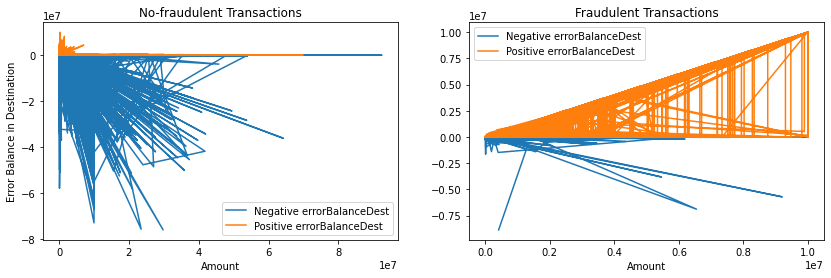

In [27]:
plotErrorsVsAmount(X[['Amount','errorBalanceDestination']], Y, False)

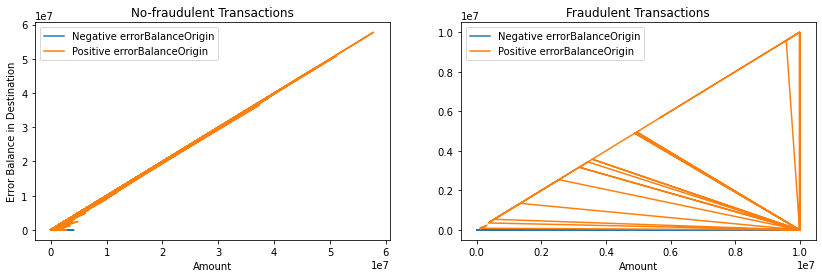

In [28]:
plotErrorsVsAmount(X[['Amount','errorBalanceOrigin']], Y)

We can see from the previous graphs that in both cases, in origin and destination accounts there is a positive error, indicating that the balance registers more money than the expected after the transacted amount was deducted from the account. Thus, this is an abnormal behaviour, which certainly can be used to model a ML algorithm to make predictions to identify if a transaction is fraudulent.

<a href='#top'>back to top</a>

The plot below shows that the transacted amount in fraudulent transactions is concentrated in short amounts of money, which confirms the previous conclusion in section <a id='analysingdata'> 2.4 Analising Data</a>.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


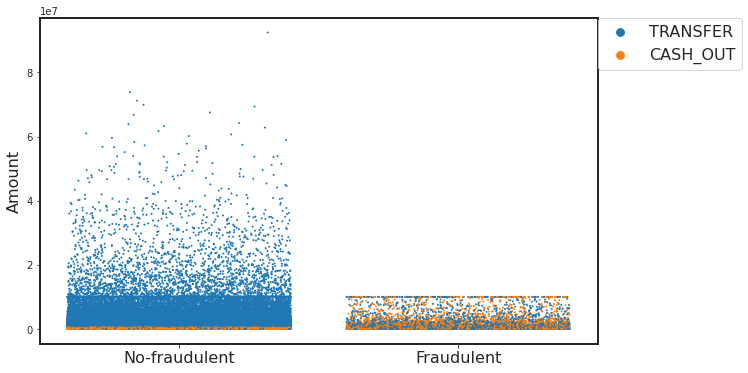

In [29]:
# To plot the label 'Y' against the column 'Amount'

fig = plt.figure(figsize=(10, 6))
colours = plt.cm.tab10(np.linspace(0, 1, 9))
with sns.axes_style('ticks'):
     ax = sns.stripplot(Y[:len(Y)], X.Amount[:len(X.Amount)], hue = X.TransactionType[:len(X.TransactionType)], jitter = 0.4, marker = '.', \
          size = 4, palette = colours)
     ax.set_xlabel('')
     ax.set_xticklabels(['No-fraudulent', 'Fraudulent'], size = 16)
     for axis in ['top','bottom','left','right']:
         ax.spines[axis].set_linewidth(2)

     handles, labels = ax.get_legend_handles_labels()
     plt.legend(handles, ['TRANSFER', 'CASH_OUT'], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, fontsize = 16);
        
ax.set_ylabel('Amount', size = 16)
#ax.set_title('Non-fraudulent and fraudulent transactions over the Amount column', size = 18);

plt.show()

<a href='#top'>back to top</a>

The correlation matrix plot below confirms that the transacted amount in fraudulent transactions has a strong correlation with the account balances, and with the created columns: errorBalanceOrigin and errorBalanceDestination.

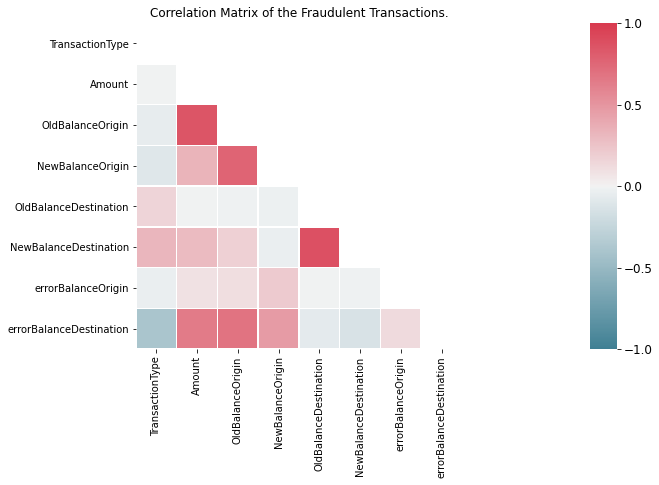

In [30]:
# To plot the correlation matrix for the fraudulent transactions

Xfraud = X.loc[Y == 1] # Clean up Xfraud
                  
correlationFraud = Xfraud.loc[:, X.columns != 'Step'].corr() # Get the correlation matrix for the the fraudulent transactions
mask = np.zeros_like(correlationFraud)
indices = np.triu_indices_from(correlationFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .05), "wspace": 0.2}

# Create the plot
f, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, \
                                     figsize = (10, 6)) 

cmap = sns.diverging_palette(220, 8, as_cmap=True)

# Create a heatmap for the correlation matrix
ax =sns.heatmap(correlationFraud, ax = ax, vmin = -1, vmax = 1, \
    cmap = cmap, square = True, linewidths = 0.5, mask = mask,  \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})

ax.set_xticklabels(ax.get_xticklabels(), size = 10); # Set the x labels
ax.set_yticklabels(ax.get_yticklabels(), size = 10); # Set the y labels
ax.set_title('Correlation Matrix of the Fraudulent Transactions.', size = 12) # Set the plot title

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 12);



<a href='#top'>back to top</a>

<a id='modeling'></a>
#### 4. Modeling

For answering the question: <a id='fraud-preds'>1.5 Is it possible to predict that a specific transaction is suspicious of fraud?</a>

In this section, it be will modelled a suitable ML algorithm to make accurate predictions for detecting if a transaction is fraudulent, based on the dataset including the engineered features.

<a id='ModelSelection'></a>
#### 4.1. Model Selection 

The metric to score precision (instead to recall) will be the precision-recall curve (AUPRC) (see <a href='http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf'>Davis and Goadrich, 2006</a>, since this suitable for managing imbalanced datasets.

The first attempt would be to train a ML algorithm based on ensembles of decision trees, in order to manage imbalanced data, which is the case of the fraud transactions compared to the no-fraudulent transactions in this dataset. For this purpose, it will be used the extreme gradient-boosted (XGBoost) algorithm (a random forest implementation). This algorithm would manage the weightings between the positive (fraudulent transactions) and negative classes (non-fraudulent transactions).


The data split will be, training data in 80% and test data in 20%.

<a href='#top'>back to top</a>

<a id='ModelTraining'></a>
#### 4.2 Model Training and Testing 

In [31]:
# To get the same sample distribution
randomState = 5
np.random.seed(randomState)

XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

In [32]:
# To train a extreme gradient boost model

weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 3)
XGBoostModel = clf.fit(XTrain, YTrain)

# To get the probabilities predictions

probas = XGBoostModel.predict_proba(XTest)
print('The probabilities average AUPRC is = {}'.format(average_precision_score(YTest, probas[:, 1])))

The probabilities average AUPRC is = 0.9970161789625528


In [33]:
print(probas[:5])

[[9.9999875e-01 1.2434482e-06]
 [9.9999917e-01 8.0900645e-07]
 [1.0000000e+00 8.3881469e-15]
 [1.0000000e+00 1.4599245e-09]
 [9.9983144e-01 1.6853685e-04]]


<a href='#top'>back to top</a>

The figure below shows that the new feature *errorBalanceOrig* that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.

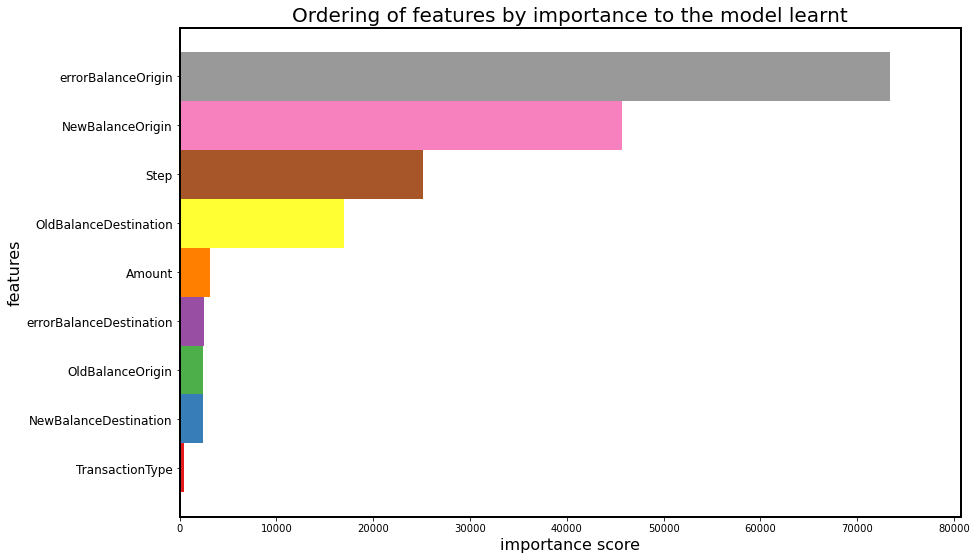

In [34]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

<a href='#top'>back to top</a>

<a id='ModelVisualization'></a>
#### 4.3 Model Visualization

The root node
in the decision tree visualized below is indeed
the feature *errorBalanceOrig*, 
as would be expected from its high significance to the
model.

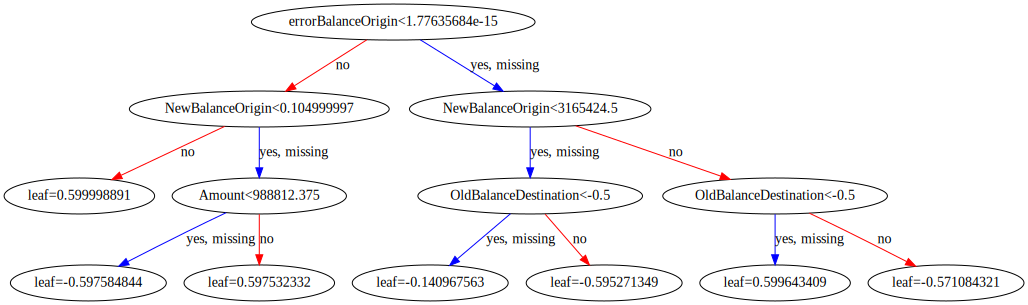

In [35]:
# To plot the resulted decision tree from the previous trained algorithm
to_graphviz(clf)

<a href='#top'>back to top</a>

<a id='evaluation'></a>
#### 5. Evaluation

<a id='biasvariance'></a>
##### 5.1 Bias-variance tradeoff

The AUPRC is shown in the cross-validation curve plot below, which indicates that the model has some bias and then might be little bit underfitted. Thus, the trees' depth can be increased to make the model more complex and to correct the underfitting (max_depth parameter, even this will make the performance time longer), and other possibilities to use for getting a precise result (for underfitting) would be decreasing min_child_weight and decreasing reg_lambda.

Therefore, in this analysis it will be tried the first approach which is to increase the trees' depth from 3 to 4. From the results below, it can be observed that the AUPRC is improved.

In [36]:
# Creating the learning curves for the XGBC classifier with a 3 tree depth

trainingSizes, trainingScores, crossValidationScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), XTrain,\
                                         YTrain, scoring = 'average_precision')

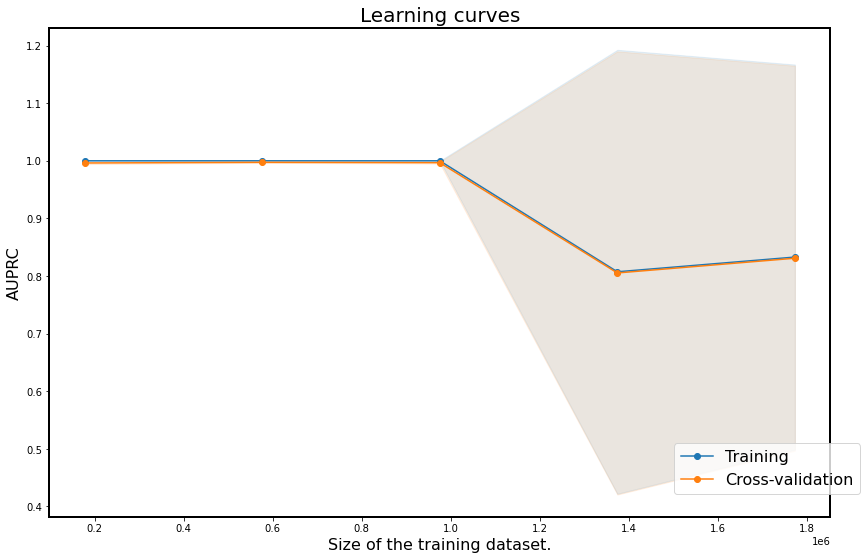

In [38]:
# Plotting the leaning curve for the algorith XGBC classifier

TScoresMean = np.mean(trainingScores, axis=1)
TScoresStd = np.std(trainingScores, axis=1)
crossValidationScoresMean = np.mean(crossValidationScores, axis=1)
crossValidationScoresStd = np.std(crossValidationScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainingSizes, TScoresMean - TScoresStd,
    TScoresMean + TScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainingSizes, crossValidationScoresMean - crossValidationScoresStd,
    crossValidationScoresMean + crossValidationScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainingSizes, trainingScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainingSizes, crossValidationScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['Training', 'Cross-validation'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('Size of the training dataset.', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves', size = 20);

In [39]:
# To train a extreme gradient boost model with a deeper tree's level, in order 4.

weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 4, scale_pos_weight = weights, n_jobs = 3)
XGBoostModel = clf.fit(XTrain, YTrain)

# To get the probabilities predictions

probas = XGBoostModel.predict_proba(XTest)
print('The probabilities average AUPRC is = {}'.format(average_precision_score(YTest, probas[:, 1])))

The probabilities average AUPRC is = 0.9982123093121237


<a href='#top'>back to top</a>

<a id='deployment'></a>
#### 6. Deployment

This model is suitable to be deployed in a real setting, however, the computation times should be changed, by adjusting the ML algorithm's parameters, in order to be used with quasi real-time requirements.

<a id='conclusion'></a>
#### 7. Conclusion

1. The proportion of fraudulent transactions compared to the non-fraudulent ones produces skew data. This imbalance in the collected data makes challenging to establish surveillance methods for fraud suspicious transactions.

2. The transacted money in large amounts is not the main concern in money laundering, but the short-amount ones.

3. Fraudulent transactions can occurred in either types, cash out or transfer, which means that fraudsters are using not only payment methods, but also transactions through financial institutions.

4. An unchanged balance in origin and destination accounts with a non-zero transacted amount is a strong indicator of fraudulent transactions. This is particular recurrent in dormant or inactive accounts.

5. It is possible to provide a method to predict if a transaction is suspicious, by the means of training ML algorithms, which allows to adjust the parameters to get precise results.

<b>Acknowledgements: </b>
Thanks to EdgarLopez-Rojas <a href='https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION'>[1]</a> for providing the sythetic financial data, which has been so helpful for this analysis, and to Jesin Fahad <a href='https://www.kaggle.com/jesyfax/predicting-fraud-in-financial-payment-services'>[2]</a> for her excellent data and ML analysis, from which I've learnt a lot.
<p><b>References: </b>
[1] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016.</p>

Link to complete data: https://www.kaggle.com/ntnu-testimon/paysim1


<a href='#top'>back to top</a>